In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTE, SMOTENC 
from collections import Counter
from sklearn.preprocessing import StandardScaler
from math import sqrt

def get_train_test(dataset_name, path, r_seed):
    if dataset_name == "HeartRisk":
        print("Loading Heart")
        print("------------------------------------------------------------")
        heart_train_risk_path = path + "Dataset-Merged.xlsx"
        dataset = pd.read_excel(heart_train_risk_path).drop(columns = ["P_ID"])
        
        
        target = "HeartRisk"
        binary = ['male', 'smoker?', 'BPMeds', 'prevalentStroke', 
                        'prevalentHyp', 'diabetes']
        categoricals = None
        fairness = ["male"]
        
        dataset = dataset.dropna()
        
        miss_values_features = ["edu", "cigsPerDay", "BPMeds", "totChol", "glucose"]
        for f in miss_values_features:
            dataset = dataset.drop(dataset[dataset[f] == -1].index)

        test_size = 0.2
    elif dataset_name == "cancer":
        print("Loading Cancer")
        print("------------------------------------------------------------")
        cancer_path = path + "wdbc2.csv"
        dataset = pd.read_csv(cancer_path, sep=',').drop(columns = ["ID"])
        target = "cancer type"
        categoricals = None
        fairness = None
        binary = None
        test_size = 0.2
    elif dataset_name == "adult":
        print("Loading Adult")
        print("------------------------------------------------------------")
        adult_path = path + "adult.csv"
        dataset = pd.read_csv(adult_path, sep=',').drop(columns = ["ID"])
        target = "class"
        categoricals = ['workclass', 'education', 'marital-status', 'occupation',
                        'relationship', 'race', 'sex', 'native-country']
        fairness = ["sex"]
        dataset = dataset.dropna()
        test_size = 0.2
    elif dataset_name == "kidney":
        print("Loading Kidney")
        print("------------------------------------------------------------")
        kidney_path = path + "kidney.csv"
        dataset = pd.read_csv(kidney_path, sep=',')
        target = "class"
        categoricals = ["sg", "al", "su"]
        fairness = None
        binary = ["rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane"]
        dataset = dataset.dropna()
        for f in dataset.columns:
            dataset = dataset.drop(dataset[dataset[f] == '?'].index)
        test_size = 0.4
    elif dataset_name == "credit":
        credit_card_path = path + "credit.csv"
        dataset = pd.read_csv(credit_card_path, sep = ',')
        target = "default payment next month"
        categoricals = ["EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3"
                        , "PAY_4", "PAY_5", "PAY_6"]
        fairness = ["SEX"]
        binary = ["SEX"]
        
        test_size = 0.2
    elif dataset_name == "student":
        print("Loading Student")
        print("------------------------------------------------------------")
        student_path = path + "student.csv"
        dataset = pd.read_csv(student_path, sep = ',')
        target = "class"
        categoricals = ["Mjob", "Fjob", "reason", "guardian"]
        fairness = ["sex"]
        binary = ["school", "sex","address", "famsize", "Pstatus", "schoolsup", "famsup", 
                  "paid", "activities", "nursery", "higher", "internet", "romantic"]
        
        test_size = 0.2
        
    else:
        raise Exception("DATASET INESISTENTE")
    if categoricals != None:
        for f in categoricals:
            one_hot = pd.get_dummies(dataset[f], 
                                     prefix = f)
            dataset = dataset.drop(columns = [f])
            dataset = dataset.join(one_hot)
    
        dataset = dataset[[c for c in dataset if c not in [target]] + [target]]
    train_set, test_set = train_test_split(dataset, test_size = test_size, random_state = r_seed, 
                                           stratify = dataset[target])
        
    return train_set, test_set, list(train_set.columns[:-1]), categoricals, binary, fairness



def preprocess(dataset, train_samples, train_labels, test_samples, test_labels, r_seed, 
               columns, categoricals, binary, fairness):
    if categoricals != None:
        categoricals_idx = [columns.index(c2) for c1 in categoricals for c2 in columns if c2.startswith(c1+"_")]
    else:
        categoricals_idx = []
        
    if binary != None:
        binary_idx = [columns.index(c1) for c1 in binary for c2 in columns if c2 == c1]
    else:
        binary_idx = []
      
    num_features_idx = list(set(range(len(columns)))-set(categoricals_idx)-set(binary_idx))
    
    if fairness != None:
        fairness_idx = [columns.index(c1) for c1 in fairness for c2 in columns if c2 == c1]
    else:
        fairness_idx = []

    std = StandardScaler()
    std.fit(train_samples[:,num_features_idx])
    train_samples[:,num_features_idx] = std.transform(train_samples[:,num_features_idx])
    test_samples[:,num_features_idx] = std.transform(test_samples[:,num_features_idx])
    
    if categoricals != None or binary != None:
        rescale_idx = categoricals_idx + binary_idx
        #print(rescale_idx)
        train_samples[:,rescale_idx] = np.where(train_samples[:,rescale_idx] == 0, -1, train_samples[:,rescale_idx])
        test_samples[:,rescale_idx] = np.where(test_samples[:,rescale_idx] == 0, -1, test_samples[:,rescale_idx])
        sm = SMOTENC(categorical_features = rescale_idx, random_state = r_seed)
    else:
        sm = SMOTE(random_state = r_seed)
    train_samples, train_labels = sm.fit_resample(train_samples, train_labels)
    test_samples, test_labels = sm.fit_resample(test_samples, test_labels)
    
    if fairness != None:
        samples = np.concatenate((train_samples, test_samples))
        males = [i for i in range(samples.shape[0]) if samples[i,fairness_idx] == 1]
        females = [i for i in range(samples.shape[0]) if samples[i,fairness_idx] == -1]
    else:
        males = None
        females = None
        
    
    return train_samples, train_labels, test_samples, test_labels, males, females

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    def __init__(self, test_samples, test_labels, patience = 2, min_iterations = 10):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.min_iterations = min_iterations
        self.patience = patience
        self.samples = test_samples
        self.labels = test_labels
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        """#predictions = (self.model.predict(self.samples) > 0.5).astype("int32")
        predictions = self.model.predict(self.samples)
        loss = tf.keras.losses.get("binary_crossentropy")
        #current = np.mean(loss(self.labels, predictions))"""
        current = self.model.evaluate(self.samples, self.labels, verbose = 0)[0]
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        elif epoch >= self.min_iterations:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
                

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

def compute_model(train_samples, train_labels, test_samples, test_labels, file_path, model_layers, 
                  patience = 2, min_iterations = 10, regularizer = None):
    input_dim = train_samples.shape[1]
    if regularizer == "l1":
        regularizer = tf.keras.regularizers.l1(l1 = 0.0001)
    elif regularizer == "l2":
        regularizer = tf.keras.regularizers.l2(l2 = 0.0001)
    elif regularizer == "l1_l2":
        regularizer = tf.keras.regularizers.l1_l2(l1 = 0.0001, l2 = 0.0001)
    n_class = 1
    if(not os.path.isdir(file_path)):
        if model_layers == 1:
            model = Sequential([Dense(units = input_dim, input_shape= (input_dim,),
                                      activation = "relu", kernel_regularizer=regularizer),
                Dense(units = n_class, activation = "sigmoid")])
        else:
            model = Sequential([Dense(units = input_dim, input_shape= (input_dim,), 
                                      activation = "relu", kernel_regularizer=regularizer),
                Dense(units = input_dim/2, activation = "relu", kernel_regularizer=regularizer),
                Dense(units = n_class, activation = "sigmoid")])
        early_stopping = EarlyStoppingAtMinLoss(test_samples, test_labels, patience, min_iterations)
        callbacks = [early_stopping]
            
        model.compile(optimizer = Adam(learning_rate = 0.001), 
                      loss = "binary_crossentropy", metrics = ["binary_accuracy"])
        
        history = model.fit(x = train_samples, y = train_labels, batch_size = 10, 
                            epochs = 1000, verbose = 1, callbacks = callbacks) 
        
        np.save(file_path+".npy", history.history)
        
        model.save(file_path)
    
def evaluate_model(model, train_samples, train_labels, test_samples, test_labels):  
    print("Evaluate on train data")
    print("TRAIN: ")
    train_pred = (model.predict(train_samples) > 0.5).astype("int32")
    dict_train = classification_report(train_labels, train_pred, output_dict = True)
    fpr, tpr, thresholds = roc_curve(train_labels, train_pred)
    auc_train = auc(fpr, tpr)
    print("AUC: ", auc(fpr, tpr))
    print("___________________________________________________________")
    
    print("Evaluate on test data")
    print("TEST: ")
    test_pred = (model.predict(test_samples) > 0.5).astype("int32")
    dict_test = classification_report(test_labels, test_pred, output_dict = True)
    preds = model.predict(test_samples)
    fpr, tpr, thresholds = roc_curve(test_labels, test_pred)
    auc_test = auc(fpr, tpr)
    print("AUC: ", auc(fpr, tpr))
    print("___________________________________________________________")
    return dict_train, dict_test, auc_train, auc_test
    
def confusion_matrix(model, samples, labels):
    predictions = (model.predict(samples) > 0.5).astype("int32")
    tp = []
    tn = []
    fp = []
    fn = []
    for i in range(samples.shape[0]):
        if predictions[i] == 1 and labels[i] == 1:
            tp.append(i)
        elif predictions[i] == 0 and labels[i] == 0:
            tn.append(i)
        elif predictions[i] == 0 and labels[i] == 1:
            fn.append(i)
        elif predictions[i] == 1 and labels[i] == 0:
            fp.append(i)
    tp = np.asarray(tp)
    tn = np.asarray(tn)
    fp = np.asarray(fp)
    fn = np.asarray(fn)
    print(len(tp), len(tn), len(fp), len(fn))
    print("_____________________________________________________________")
    return tp, tn, fp, fn


In [22]:
import numpy as np
import statistics
import os
import time
import csv
import shap
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
from scipy.spatial import distance

def compute_shap_values(file_path, samples, columns, explainer):
    if(not os.path.isfile(file_path + ".tsv")):
            print("START CALCULATING SHAP VALUES...")
            shap_values = explainer.shap_values(samples, silent = True)
            print("END CALCULATING SHAP VALUES")
            pd.DataFrame(shap_values[0]).to_csv(file_path + ".tsv", sep = "\t",
                                                index = False)
            
            shap.summary_plot(shap_values, samples, feature_names = columns, show=False)
            plt.savefig(file_path + ".png")
            plt.clf()
            print("_____________________________________________________________________")

def get_shap_values(file_path, model, samples):
    shap_values_as_df = pd.read_csv(file_path + ".tsv", sep='\t')
    
    return np.asarray(shap_values_as_df).astype("float")
         

def weight_samples(shap_values, samples, scaler):
    return np.multiply(samples,np.abs(shap_values)) / scaler

In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from numpy.random import seed
import statistics
import shap
import matplotlib.pyplot as plt
import csv
import time

def save_results(dict_train, dict_test, zeros_train, zeros_test, auc_train, 
                 auc_test, file_path, title):
    with open("/".join(file_path.split("/")[:-2])+ "/results " + 
              title + ".tsv", "a") as res_file:
        tsv_writer = csv.writer(res_file, delimiter = "\t")
        print(file_path.split("/")[-1])
        tsv_writer.writerow([file_path.split("/")[-1] + " train","precision","recall", "f1", "zeros shap", "AUC", "Accuracy","Accuracy Test"])
        tsv_writer.writerow([0, dict_train["0"]["precision"], dict_train["0"]["recall"], dict_train["0"]["f1-score"]])
        tsv_writer.writerow([1, dict_train["1"]["precision"], dict_train["1"]["recall"], dict_train["1"]["f1-score"]])
        tsv_writer.writerow(["macro", dict_train["macro avg"]["precision"], 
                             dict_train["macro avg"]["recall"], dict_train["macro avg"]["f1-score"], zeros_train, auc_train,
                            dict_train["accuracy"]])
        
        tsv_writer.writerow([file_path.split("/")[-1] + " test","precision","recall", "f1"])
        tsv_writer.writerow([0, dict_test["0"]["precision"], dict_test["0"]["recall"], dict_test["0"]["f1-score"]])
        tsv_writer.writerow([1, dict_test["1"]["precision"], dict_test["1"]["recall"], dict_test["1"]["f1-score"]])
        tsv_writer.writerow(["macro", dict_test["macro avg"]["precision"], 
                             dict_test["macro avg"]["recall"], dict_test["macro avg"]["f1-score"], zeros_test, auc_test,
                            dict_test["accuracy"]])
    res_file.close()
                        
def save_confusion_matrix(tps, tns, fps, fns, title):
    with open(title + ".tsv", "w") as cf_file:
        tsv_writer = csv.writer(cf_file, delimiter = "\t")
        for i in range(len(tps)):
            tsv_writer.writerow(["Iter " + str(i) + " TPs"])
            tsv_writer.writerow(tps[i])
            tsv_writer.writerow(["Iter " + str(i) + " TNs"])
            tsv_writer.writerow(tns[i])
            tsv_writer.writerow(["Iter " + str(i) + " FPs"])
            tsv_writer.writerow(fps[i])
            tsv_writer.writerow(["Iter " + str(i) + " FNs"])
            tsv_writer.writerow(fns[i])
    cf_file.close()

def count_zeros(data):
    return np.sum([np.count_nonzero(np.abs(x) < 0.01) for x in data])

def find_replacement_values(shap_values, samples, categorical_features, binary_features, fairness_features, threshold = 0.01):
    repl_f = []
    for f in range(samples.shape[1]):
        if (f not in categorical_features) and (f not in fairness_features) and (f not in binary_features):
            
            shap_f = shap_values[:,f]
            while np.isnan(np.median(samples[:,f][np.abs(shap_f) < threshold])):
                threshold = threshold + 0.005
            
            repl_f.append(np.median(samples[:,f][np.abs(shap_f) < threshold]))
            threshold = 0.01
        else:
            repl_f.append(0)

    return np.array(repl_f)

def replace_samples(shap_values, samples, replacement_values, k):
    rows = []
    for i in range(samples.shape[0]):
        idxs = np.argsort(np.abs(shap_values[i,:]))[:-k]
        row = np.array(samples[i,:])
        row[idxs] = replacement_values[idxs]
        rows.append(row)
    return np.array(rows)

r_seed = 1


seed(r_seed)
tf.random.set_seed(r_seed)
"""
Method that runs TRV method:
    - dataset: Name of the chosen dataset. {"cancer", "HeartRisk", "student", "kidney"}
    - data_path: Path to the dataset folder
    - results_path: Path where to save the results
    - regularizer: Type of regularizer. {None, "l1", "l2", "l1_l2"}
    - title: title to append at the files names

Results saved by the method:
    - keras models trained during TRV: {n_iter}_median_model_1_hidden
    - history of the keras models: {n_iter}_median_model_1_hidden.npy
    - SHAP scores computed on the train set: {n_iter}_median_model_1_hidden.tsv and {n_iter}_median_model_1_hidden.png
    - SHAP scores computed on the test set: {n_iter}_median_model_1_hidden_test.tsv and {n_iter}_median_model_1_hidden_test.png
    - precision, recall, f1, XCP, AUC and accuracy: results {title}.tsv
    - confusion matrixs: confusion matrix {title}.tsv
"""
def main(dataset, data_path, results_path, title, regularizer = None, k = 5):
    model_layers = 1
    train_set, test_set, columns, categoricals, binary, fairness = get_train_test(dataset, data_path, r_seed)
        
    if categoricals != None:
        categoricals_idx = [columns.index(c2) for c1 in categoricals for c2 in columns if c2.startswith(c1+"_")]
    else:
        categoricals_idx = []
      
    if binary != None:
        binary_idx = [columns.index(c1) for c1 in binary for c2 in columns if c2 == c1]
    else:
        binary_idx = []
      
    num_features_idx = list(set(range(len(columns)))-set(categoricals_idx)-set(binary_idx))
    
    if fairness != None:
        fairness_idx = [columns.index(c1) for c1 in fairness for c2 in columns if c2 == c1]
    else:
        fairness_idx = []
        
    train_samples = np.asarray(train_set[train_set.columns[:-1]]).astype("float")
    train_labels = np.asarray(train_set[train_set.columns[-1]]).astype("int64")
    
    test_samples = np.asarray(test_set[test_set.columns[:-1]]).astype("float")
    test_labels = np.asarray(test_set[test_set.columns[-1]]).astype("int64")
    
    train_samples, train_labels, test_samples, test_labels, males, females = \
                preprocess(dataset, train_samples, 
                    train_labels, test_samples, 
                    test_labels, r_seed, columns,
                    categoricals, binary, fairness)

    tps = []
    tns = []
    fps = []
    fns = []
    new_train = train_samples
    new_test = test_samples
    times = []
    epochs = []
    if regularizer == None:
        n_iter = 2
    else:
        n_iter = 1
    for i in range(n_iter):
        if model_layers == 1:
            file_path = results_path + str(i) + "_median_model_1_hidden"
        elif model_layers == 2:
            file_path = results_path + str(i) + "_median_model_2_hidden"
                
        start_time = time.time()
        compute_model(new_train, train_labels, new_test, 
                      test_labels, file_path, model_layers, patience = 5, 
                      min_iterations = 10, regularizer = regularizer)
        
        model = keras.models.load_model(file_path)
        history=np.load(file_path+ '.npy',allow_pickle='TRUE').item()
        
        dict_train, dict_test, auc_train, auc_test = evaluate_model(model, new_train, 
                                               train_labels, new_test, test_labels)
        
        
        samples = new_train
        if males != None and females != None:
            
            males = [e for e in males if e < new_train.shape[0]]
            females = [e for e in females if e < new_train.shape[0]]
            
            m = samples[males]
            f = samples[females]
            
            background_sample_m = shap.kmeans(m, 2)
            background_sample_f = shap.kmeans(f, 2)
            background_sample = np.concatenate((background_sample_m.data, background_sample_f.data))
        else:
            background_sample = shap.kmeans(samples, 4).data
                
        samples = np.concatenate((new_train, new_test))
        labels = np.concatenate((train_labels, test_labels))
        tp, tn, fp, fn = confusion_matrix(model, samples, labels)
        
        explainer = shap.KernelExplainer(model.predict, background_sample)
                
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        
        shap_path = file_path
        compute_shap_values(shap_path, new_train, train_set.columns[:-1], explainer)
        shap_values_train = get_shap_values(shap_path, model, new_train)
        zeros_train = count_zeros(shap_values_train)
        zeros_train = zeros_train/(new_train.shape[0] * new_train.shape[1])

        shap_path = file_path + "_test"
        compute_shap_values(shap_path, new_test, test_set.columns[:-1], explainer)
        shap_values_test = get_shap_values(shap_path, model, new_test)
        zeros_test = count_zeros(shap_values_test)
        zeros_test = zeros_test/(new_test.shape[0] * new_test.shape[1])
        
        replacement_values = find_replacement_values(shap_values_train, new_train, 
                                                     categoricals_idx, binary_idx,
                                                     fairness_idx, threshold = 0.01)
        
        save_results(dict_train, dict_test, zeros_train, zeros_test, 
                     auc_train, auc_test, file_path, title)
        
        k = k
        new_train = replace_samples(shap_values_train, new_train, 
                                           replacement_values, k)
        
        new_test = replace_samples(shap_values_test, new_test, 
                                           replacement_values, k)
        
        
    
        time_ = time.time() - start_time
        times.append(time_)
        epochs.append(len(history['loss']))
            
    title_ = "/".join(file_path.split("/")[:-2]) + "/confusion matrix " + title
    save_confusion_matrix(tps,tns,fps,fns,title_)
    
data_path = "dataset/student/" 

results_path = "results TRV/student/1 hidden layer/"
title = "student 1 hidden"
k = 3
main("student", data_path, results_path, title, k = 3, regularizer = None)

Loading Student
------------------------------------------------------------
Epoch 1/1000
34/34 [==============================] - 0s 4ms/step - loss: 0.7326 - binary_accuracy: 0.5389
Epoch 2/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.6607 - binary_accuracy: 0.5958
Epoch 3/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.6195 - binary_accuracy: 0.6617
Epoch 4/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5976 - binary_accuracy: 0.6796
Epoch 5/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5700 - binary_accuracy: 0.7305
Epoch 6/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5510 - binary_accuracy: 0.7455
Epoch 7/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5352 - binary_accuracy: 0.7485
Epoch 8/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5200 - binary_accuracy: 0.7695
Epoch 9/1000
34/34 [==============================] - 0s 2ms/step -

Mean of empty slice.
invalid value encountered in double_scalars


34/34 [==============================] - 0s 4ms/step - loss: 0.6447 - binary_accuracy: 0.6347
Epoch 2/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.6057 - binary_accuracy: 0.6946
Epoch 3/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5763 - binary_accuracy: 0.7305
Epoch 4/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5554 - binary_accuracy: 0.7455
Epoch 5/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5329 - binary_accuracy: 0.7425
Epoch 6/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.5179 - binary_accuracy: 0.7485
Epoch 7/1000
34/34 [==============================] - 0s 3ms/step - loss: 0.5052 - binary_accuracy: 0.7485
Epoch 8/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.4951 - binary_accuracy: 0.7635
Epoch 9/1000
34/34 [==============================] - 0s 2ms/step - loss: 0.4864 - binary_accuracy: 0.7605
Epoch 10/1000
34/34 [=============================

Mean of empty slice.
invalid value encountered in double_scalars


<Figure size 576x684 with 0 Axes>

Loading Heart
------------------------------------------------------------
15
Loading Heart
------------------------------------------------------------
15
Loading Heart
------------------------------------------------------------
15
Loading Heart
------------------------------------------------------------
15
Loading Heart
------------------------------------------------------------
15
Positive predictive parity
Negative predictive parity
False positive parity
Equality of opportunity
6
Loading Student
------------------------------------------------------------
26
Loading Student
------------------------------------------------------------
26


C:\Users\Utente\AppData\Local\Temp/ipykernel_14728/3659022439.py:352: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.set_xticklabels(labels = labels, rotation = 90, fontsize = 26)


Loading Student
------------------------------------------------------------
26
Loading Student
------------------------------------------------------------
26
Loading Student
------------------------------------------------------------
26
Positive predictive parity
Negative predictive parity
False positive parity
Equality of opportunity
6
Loading Heart
------------------------------------------------------------
15
Positive predictive parity
Negative predictive parity
False positive parity
Equality of opportunity
1
Loading Student
------------------------------------------------------------
26
Positive predictive parity
Negative predictive parity
False positive parity
Equality of opportunity
1
Loading Heart
------------------------------------------------------------
15
Positive predictive parity
Negative predictive parity
False positive parity
Equality of opportunity
1
Loading Student
------------------------------------------------------------
26
Positive predictive parity
Negative 

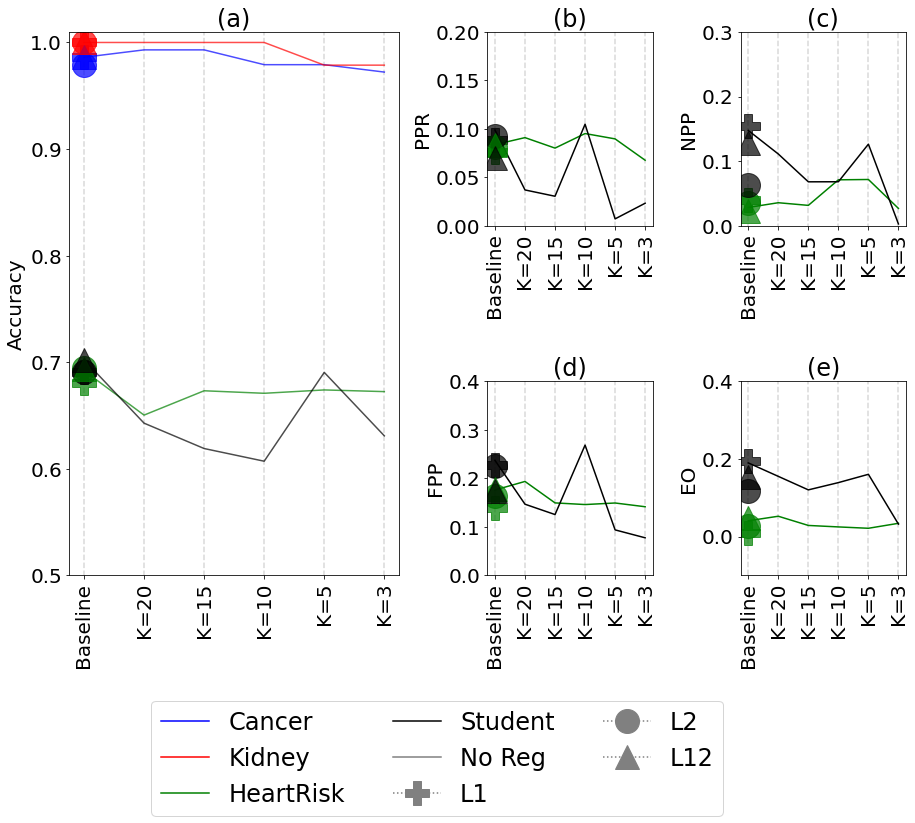

In [20]:
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras

import keras
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from numpy.random import seed
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score
import csv
from collections import defaultdict
import pandas as pd

def demographic_parity(tps, tns, fps, fns):
    dps = []
    for i in range(len(tps)):
       dp = np.round((len(tps[i]) + len(fps[i]))/(len(tns[i]) + len(fns[i])),4)
       dps.append(dp)
    return dps

def positive_pred_rate(tps, fps):
    pprs = []
    for i in range(len(tps)):
       ppr = np.round((len(tps[i]))/(len(tps[i]) + len(fps[i])), 4)
       pprs.append(ppr)
    return pprs

def negative_pred_rate(tns, fns):
    nprs = []
    for i in range(len(tns)):
       npr = np.round((len(tns[i]))/(len(tns[i]) + len(fns[i])), 4)
       nprs.append(npr)
    return nprs

def false_positive_parity(tns, fps):
    fpps = []
    for i in range(len(tns)):
        fpp = np.round(len(fps[i])/(len(fps[i]) + len(tns[i])),4)
        fpps.append(fpp)
    return fpps

def equality_opportunity(tps, fns):
    eos = []
    for i in range(len(tps)):
        eo = np.round(len(tps[i])/(len(tps[i]) + len(fns[i])),4)
        eos.append(eo)
    return eos

def get_mf_list(lists, males, ids, m_ls, f_ls, indexes):
    for j,l in enumerate(lists):
        if j not in indexes:
            continue
        l_ = [int(x) for x in l]
        m_l = []
        f_l = []
        for elem in l_:
            if elem in males and elem >= ids:
                m_l.append(elem)
            else:
                f_l.append(elem)
        m_ls.append(m_l)
        f_ls.append(f_l)
        
rotation = 0

fig=plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace = 0.8, wspace = 0.4)
gs=GridSpec(2,3, width_ratios=(2,1,1), height_ratios=(1,1)) # 2 rows, 3 columns

ax1=plt.subplot(gs[:,0]) 
ax2=plt.subplot(gs[0,1]) 
ax3=plt.subplot(gs[0,2]) 
ax4=plt.subplot(gs[1,1]) 
ax5=plt.subplot(gs[1,2]) 

labels = ["Baseline","K=20", "K=15", "K=10", "K=5", "K=3"]

lines = [plt.Line2D([0], [0], color = "b", linestyle = "-"),
         plt.Line2D([0], [0], color = "r", linestyle = "-"),
         plt.Line2D([0], [0], color = "g", linestyle = "-"),
         plt.Line2D([0], [0], color = "k", linestyle = "-"),
         plt.Line2D([0], [0], color = "grey", linestyle = "-"),
         plt.Line2D([0], [0], color = "grey", linestyle = ":", marker = "P", markersize = 24),
         plt.Line2D([0], [0], color = "grey", linestyle = ":", marker = "o", markersize = 24),
         plt.Line2D([0], [0], color = "grey", linestyle = ":", marker = "^", markersize = 24)]
labs = ["Cancer", "Kidney", "HeartRisk", "Student", "No Reg","L1", "L2", "L12"]
for i in range(len(labels)):
    ax1.vlines(i,-1,1.1,color = "grey", linestyles="dashed", alpha = 0.3)
    ax2.vlines(i,-1,1.1,color = "grey", linestyles="dashed", alpha = 0.3)
    ax3.vlines(i,-1,1.1,color = "grey", linestyles="dashed", alpha = 0.3)
    ax4.vlines(i,-1,1.1,color = "grey", linestyles="dashed", alpha = 0.3)
    ax5.vlines(i,-1,1.1,color = "grey", linestyles="dashed", alpha = 0.3)

r_seed = 1

seed(r_seed)
tf.random.set_seed(r_seed)

box = ax5.get_position()
ax5.set_position([box.x0, box.y0, box.width, box.height])
legend_x = 1
legend_y = 0
ax2.legend(lines, labs, loc = 4, fontsize = 24, ncol = 3, bbox_to_anchor=(legend_x+0.5, legend_y-3.1))

styles = ["-", ":P", ":o", ":^"]
regs = ["", "L1 ", "L2 ", "L12 "]
colors = ["b","r","g","k"]
datasets = ["cancer", "kidney", "heart", "student"]

path = "results TRV/"
for reg in regs:
    style = styles[regs.index(reg)]
    for dataset in datasets:

        color = colors[datasets.index(dataset)]
        if dataset == "heart":
            dataset_ = "HeartRisk"
        else:
            dataset_ = dataset
        ks = [20,15,10,5,3]
        if reg == "":
            indexes = [0,1,3,5,7,9]
        else:
            indexes = [0]

        accs = []
        for k in ks:
            if k == 20 or reg == "":
                file = open(path + "K "+str(k)+"/"+dataset+"/risultati " + reg + dataset_ + " 1 hidden.tsv")

                res = pd.read_csv(file, sep='\t')

                accs.append(res[res[res.columns[0]] == "macro"]["Accuracy"].to_numpy(dtype="float64"))

        accs = np.array(accs).flatten()   

        accs_train = accs[0::2]
        accs_train = accs_train[indexes]

        accs_test = accs[1::2]
        accs_test = accs_test[indexes]


        steps = len(labels)

        ax1.set_ylim(0.5, 1.01)
        ax1.set_yticks(np.arange(0.5,1.05,0.1))
        ax1.set_yticklabels(labels = np.round(np.arange(0.51,1.05,0.1),1), fontsize = 20)
        ax1.set_xticks(np.arange(0,steps,1))
        ax1.set_xticklabels(labels = labels, rotation = 90, fontsize = 20) 
        if reg == "":
            ax1.plot(accs_test, style, color = color, markersize = 24, alpha = 0.7)
        else:
            ax1.plot(accs_test[0], style, color = color, markersize = 24, alpha = 0.7)
        ax1.set_ylabel("Accuracy", fontsize = 20)
        ax1.set_title("(a)", fontsize = 24)

colors = ["g", "k"]
datasets = ["heart", "student"]
regs = ["", "L1 ", "L2 ", "L12 "]
styles = ["-", ":P", ":o", ":^"]
for reg in regs:
    if reg == "":
        indexes = [0,1,3,5,7,9]
    else:
        indexes = [0]
    for dataset in datasets:
        color = colors[datasets.index(dataset)]
        if dataset == "heart":
            dataset_ = "HeartRisk"
        else:
            dataset_ = dataset
        ks = [20,15,10,5,3]

        m_pprs = []
        f_pprs = []
        m_nprs = []
        f_nprs = []
        m_fpps = []
        f_fpps = []
        m_eos = []
        f_eos = []


        tps = []
        tns = []
        fps = []
        fns = []
        for k in ks:
            if reg == "" or k == 20:
                path_ = path+ "K "+str(k)+"/"+dataset+"/confusion matrix "+ reg + dataset_ + " 1 hidden.tsv"
                data_path = "dataset/"+dataset+"/"

                train_set, test_set, columns, categoricals, binary, fairness = get_train_test(dataset_, data_path, r_seed)

                if categoricals != None:
                    categoricals_idx = [columns.index(c2) for c1 in categoricals for c2 in columns if c2.startswith(c1+"_")]
                else:
                    categoricals_idx = []

                num_features_idx = list(set(range(len(columns)))-set(categoricals_idx))

                if fairness != None:
                    fairness_idx = [columns.index(c2) for c1 in fairness for c2 in columns if c2.startswith(c1+"_")]
                else:
                    fairness_idx = []

                train_samples = np.asarray(train_set[train_set.columns[:-1]]).astype("float")
                train_labels = np.asarray(train_set[train_set.columns[-1]]).astype("int64")


                test_samples = np.asarray(test_set[test_set.columns[:-1]]).astype("float")
                test_labels = np.asarray(test_set[test_set.columns[-1]]).astype("int64")

                train_samples, train_labels, test_samples, test_labels, males, females = \
                            preprocess(dataset_, train_samples, 
                                train_labels, test_samples, 
                                test_labels, r_seed, columns,
                                categoricals, binary, fairness)






                new_train2 = train_samples
                new_test2 = test_samples

                train_labels2 = train_labels
                test_labels2 = test_labels

                samples2 = np.concatenate((new_train2, new_test2))
                labels2 = np.concatenate((train_labels2, test_labels2))



                file = open(path_)
                read_tsv = csv.reader(file, delimiter="\t")
                i = 0
                flag = -1
                for row in read_tsv:
                    if row == []:
                        continue

                    if flag == 0:
                        r = row
                        tps.append(r)
                    elif flag == 1:
                        r = row
                        tns.append(r)
                    elif flag == 2:
                        r = row
                        fps.append(r)
                    elif flag == 3:
                        r = row
                        fns.append(r)

                    if row[0].endswith("TPs"):
                        flag = 0
                    elif row[0].endswith("TNs"):
                        flag = 1
                    elif row[0].endswith("FPs"):
                        flag = 2
                    elif row[0].endswith("FNs"):
                        flag = 3
                    else:
                        flag = -1


                    i += 1

        m_tps = []
        f_tps = []
        m_tns = []
        f_tns = []
        m_fps = []
        f_fps = []
        m_fns = []
        f_fns = []
        get_mf_list(tps, males, train_samples.shape[0], m_tps, f_tps, indexes)
        get_mf_list(tns, males, train_samples.shape[0], m_tns, f_tns, indexes)
        get_mf_list(fps, males, train_samples.shape[0], m_fps, f_fps, indexes)
        get_mf_list(fns, males, train_samples.shape[0], m_fns, f_fns, indexes)


        style = styles[regs.index(reg)]

        m_pprs = np.array(positive_pred_rate(m_tps, m_fps))
        f_pprs = np.array(positive_pred_rate(f_tps, f_fps))
        ax2.set_ylim(0,0.2)

        m_nprs = np.array(negative_pred_rate(m_tns, m_fns))
        f_nprs = np.array(negative_pred_rate(f_tns, f_fns))
        ax3.set_ylim(-0,0.3)

        m_fpps = np.array(false_positive_parity(m_tns, m_fps))
        f_fpps = np.array(false_positive_parity(f_tns, f_fps))
        ax4.set_ylim(-0,0.4)

        m_eos = np.array(equality_opportunity(m_tps, m_fns))
        f_eos = np.array(equality_opportunity(f_tps, f_fns))
        ax5.set_ylim(-0.1,0.4)


        print(len(m_pprs))
        m_pprs = np.array(m_pprs)
        f_pprs = np.array(f_pprs)
        m_nprs = np.array(m_nprs)
        f_nprs = np.array(f_nprs)
        m_fpps = np.array(m_fpps)
        f_fpps = np.array(f_fpps)
        m_eos = np.array(m_eos)
        f_eos = np.array(f_eos)
        if reg == "":
            ax2.plot(abs(m_pprs-f_pprs), style, color = color)
            ax2.set_xticks(np.arange(0,6,1))
            labels = ["Baseline","K=20", "K=15", "K=10", "K=5", "K=3"]
            ax2.set_xticklabels(labels = labels, rotation = 90, fontsize = 26) 
        else:
            ax2.plot(abs(m_pprs[0]-f_pprs[0]), style, color = color, markersize = 24, alpha = 0.7)

        ax2.set_ylabel("PPR", fontsize = 20)
        ax2.tick_params(axis='both', which='major', labelsize=20)
        ax2.set_title("(b)", fontsize = 24)


        if reg == "":
            ax3.plot(abs(m_nprs-f_nprs), style, color = color)
            ax3.set_xticks(np.arange(0,6,1))
            labels = ["Baseline","K=20", "K=15", "K=10", "K=5", "K=3"]
            ax3.set_xticklabels(labels = labels, rotation = 90, fontsize = 26) 
        else:
            ax3.plot(abs(m_nprs[0]-f_nprs[0]), style, color = color, markersize = 24, alpha = 0.7)

        ax3.set_ylabel("NPP", fontsize = 20)
        ax3.tick_params(axis='both', which='major', labelsize=20)
        ax3.set_title("(c)", fontsize = 24)


        if reg == "":
            labels = ["Baseline","K=20", "K=15", "K=10", "K=5", "K=3"]
            ax4.set_xticklabels(labels = labels, rotation = 90, fontsize = 26) 
            ax4.set_xticks(np.arange(0,6,1))
            ax4.plot(abs(m_fpps-f_fpps), style, color = color)
        else:
            ax4.plot(abs(m_fpps[0]-f_fpps[0]), style, color = color, markersize = 24, alpha = 0.7)

        ax4.set_ylabel("FPP", fontsize = 20)
        ax4.tick_params(axis='both', which='major', labelsize=20)
        ax4.set_title("(d)", fontsize = 24)


        if reg == "":
            ax5.set_xticks(np.arange(0,6,1))
            labels = ["Baseline","K=20", "K=15", "K=10", "K=5", "K=3"]
            ax5.set_xticklabels(labels = labels, rotation = 90, fontsize = 20) 
            ax5.plot(abs(m_eos-f_eos), style, color = color)
        else:
            ax5.plot(abs(m_eos[0]-f_eos[0]), style, color = color, markersize = 24, alpha = 0.7)

        ax5.tick_params(axis='both', which='major', labelsize=20)
        ax5.set_ylabel("EO", fontsize = 20)      
        ax5.set_title("(e)", fontsize = 24)

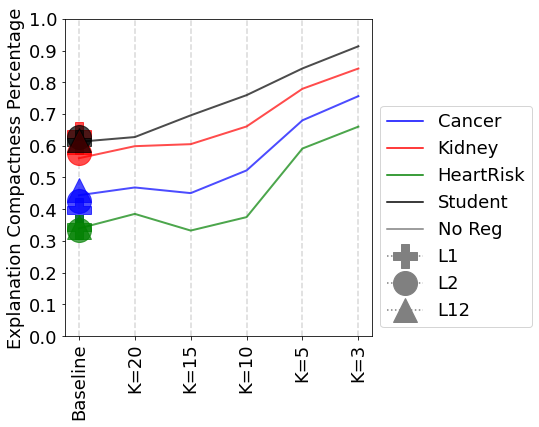

In [24]:
n_fig = 1
rotation = 90

f, ax1 = plt.subplots(1,1, figsize = (5,5))
f.subplots_adjust(wspace = 0.6)
f.tight_layout()


labels = ["Baseline", "K=20", "K=15", "K=10", "K=5", "K=3"]


lines = [plt.Line2D([0], [0], color = "b", linestyle = "-"),
         plt.Line2D([0], [0], color = "r", linestyle = "-"),
         plt.Line2D([0], [0], color = "g", linestyle = "-"),
         plt.Line2D([0], [0], color = "k", linestyle = "-"),
         plt.Line2D([0], [0], color = "grey", linestyle = "-"),
         plt.Line2D([0], [0], color = "grey", linestyle = ":", marker = "P", markersize = 24),
         plt.Line2D([0], [0], color = "grey", linestyle = ":", marker = "o", markersize = 24),
         plt.Line2D([0], [0], color = "grey", linestyle = ":", marker = "^", markersize = 24)]
labs = ["Cancer", "Kidney", "HeartRisk", "Student", "No Reg","L1", "L2", "L12"]
for i in range(len(labels)):
    ax1.vlines(i,-1,1.1,color = "grey", linestyles="dashed", alpha = 0.3)


box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width, box.height])
legend_x = 1
legend_y = 0
ax1.legend(lines, labs, loc = 4, fontsize = 18, ncol = 1, bbox_to_anchor=(legend_x+0.55, legend_y))
  
styles = ["-", ":P", ":o", ":^"]
regs = ["", "L1 ", "L2 ", "L12 "]
colors = ["b","r","g","k"]
datasets = ["cancer", "kidney", "heart", "student"]
ax1.set_ylim(0., 1.01)
ax1.set_yticks(np.arange(0.,1.05,0.1))
ax1.set_yticklabels(labels = np.round(np.arange(0.,1.05,0.1),1), fontsize = 18)
ax1.set_xticks(np.arange(0,len(labels),1))
ax1.set_xticklabels(labels = labels, rotation = 90, fontsize = 18) 
for reg in regs:
    style = styles[regs.index(reg)]
    
    for dataset in datasets:
        color = colors[datasets.index(dataset)]
        if dataset == "heart":
            dataset_ = "HeartRisk"
        else:
            dataset_ = dataset
        ax1.set_ylim(0.,1)
        ax1.set_xticks(np.arange(0,6))
        ax1.set_xticklabels(labels)
        
        ks = [20,15,10,5,3]
        shaps = []
        for k in ks:
            if k == 20 and reg == "":
                indexes = [0,1]
            elif reg != "" and k == 20:
                indexes = [0]
            elif k != 20 and reg == "":
                indexes = [1]
            else:
                indexes = []
            for i in indexes:
                path = "results TRV/K "+str(k)+"/"+dataset+"/"+reg+"1 hidden layer/"+str(i)+"_median_model_1_hidden_test"
                
                shap_train = get_shap_values(path, None, None)
    
                den = shap_train.shape[0] * shap_train.shape[1]
                shaps.append(np.count_nonzero(np.abs(shap_train) < 0.01)/den)
        
        ax1.plot(shaps, style, color = color, markersize = 24, lw = 2, alpha = 0.7)
        ax1.set_ylabel("Explanation Compactness Percentage", fontsize = 18)

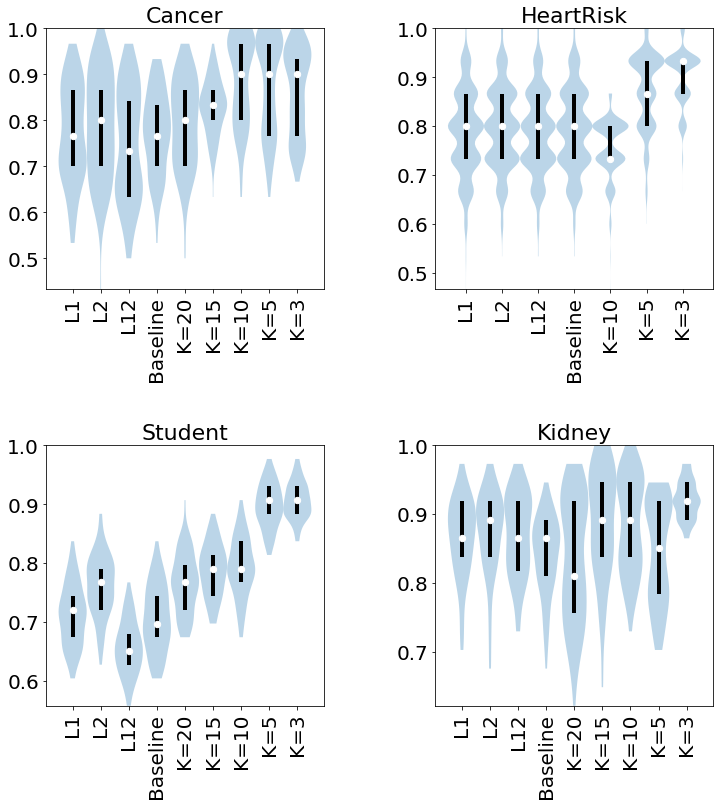

In [27]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score
import csv
from collections import defaultdict
from matplotlib.gridspec import GridSpec
import tensorflow as tf
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import spearmanr
import pandas as pd

regs = ["L1 ", "L2 ", "L12 ", ""]
datasets = ["cancer", "heart", "student", "kidney"]
lw = 2
colors = plt.cm.brg(np.linspace(0.0,0.9,9))
f, ax = plt.subplots(2,2, figsize = (10,10))
f.tight_layout()
f.subplots_adjust(hspace = 0.6, wspace = 0.4)



    
for dataset in datasets:
    shaps = []
    for reg in regs:
        color = colors[datasets.index(dataset)]
        ks = [20,15,10,5,3]
        if dataset == "heart":
            dataset_ = "HeartRisk"
            labels = ["","L1", "L2","L12","Baseline","K=10", "K=5", "K=3"]
            ks = [20,10,5,3]
            title = dataset_
        else:
            dataset_ = dataset
            labels = ["","L1", "L2","L12","Baseline","K=20", "K=15", "K=10", "K=5", "K=3"]
            title = dataset_.capitalize()
        if dataset in ["cancer", "heart"]: row = 0
        else: row = 1
        col = datasets.index(dataset)%2
       
        
        for k in ks:
            if k == 20 and reg == "":
                if dataset != 'heart':
                    indexes = [0,1]
                else:
                    indexes = [0]
            elif reg != "" and k == 20:
                indexes = [0]
            elif k != 20 and reg == "":
                indexes = [1]
            else:
                indexes = []
            for i in indexes:
                path = "results TRV/K "+str(k)+"/"+dataset+"/"+reg+"1 hidden layer/"+str(i)+"_median_model_1_hidden_test"
                
                shap_train = get_shap_values(path, None, None)
    
                den = shap_train.shape[0] * shap_train.shape[1]
                shaps.append(shap_train)
    shaps = np.array(shaps)
    t = 0.01
    jaccards = []
    for i in range(shaps.shape[0]):
        global_expl = np.mean(np.abs(shaps[i]), axis = 0)
        global_expl = np.array(np.where(global_expl > t, 1, 0))
        expls = np.array(shaps[i])
        expls = [np.where(np.abs(expls[j]) > t, 1, 0) for j in range(expls.shape[0])]
        expls = np.array(expls)

        jaccards.append(1 - pairwise_distances(expls, [global_expl], metric = 'hamming'))

    jaccards = np.array(jaccards)
    jaccards = np.reshape(jaccards, (jaccards.shape[0], jaccards.shape[1]))
    jaccards = np.transpose(jaccards)
    ax[row][col].set_ylim(np.min(jaccards),1)
    ax[row][col].violinplot(jaccards, widths=1, showextrema = False)
    ax[row][col].set_xticks(np.arange(0,len(labels)))
    ax[row][col].set_xticklabels(labels = labels, rotation = 90, fontsize = 26) 
    ax[row][col].tick_params(axis='both', which='major', labelsize=20)
    quartile1, medians, quartile3 = np.percentile(jaccards, [25, 50, 75], axis=0)
    iqr = quartile3 - quartile1
    inds = np.arange(1, len(medians) + 1)

    ax[row][col].scatter(inds, medians, marker='o', color='w', s=40, zorder=3)
    ax[row][col].vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=4)

    box = ax[1][0].get_position()
    ax[1][0].set_position([box.x0, box.y0, box.width, box.height])
    legend_x = 1
    legend_y = 0

    ax[row][col].set_title(title, fontsize = 22)

Loading Heart
------------------------------------------------------------
Loading Heart
------------------------------------------------------------


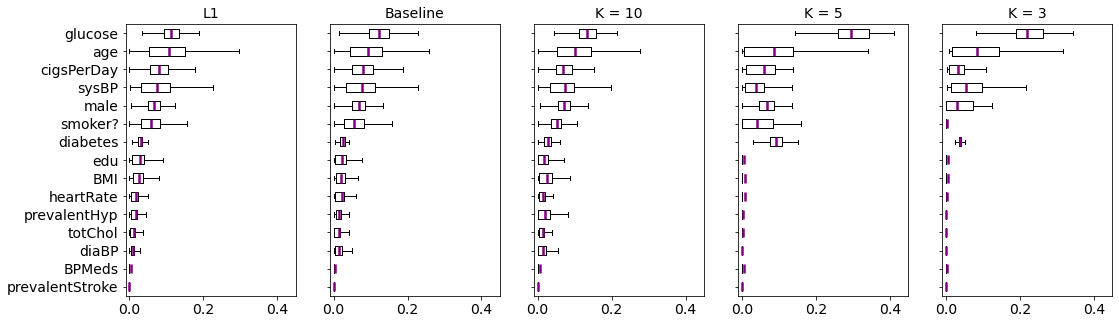

In [31]:

import numpy as np
import keras
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, precision_score
import csv
from collections import defaultdict
from matplotlib.gridspec import GridSpec
import tensorflow as tf

#SEED ORIGINALE    
r_seed = 1
#

seed(r_seed)
tf.random.set_seed(r_seed)

n_fig = 1
rotation = 90

fig=plt.figure(figsize = (25,5))
fig.subplots_adjust(hspace = 0.35, wspace = 0.2)
gs=GridSpec(1,7, width_ratios=(1,1,1,1,1,1,1)) # 2 rows, 3 columns

axis = []

for j in range(5):
    axis.append(plt.subplot(gs[j]))
  
styles = ["-", ":P", ":o", ":^"]
regs = ["L1 ", ""]
colors = ["b","r","g","k"]
datasets = ["cancer", "kidney", "heart", "student"]
datasets = ["heart"]

shaps = []
for reg in regs:
    style = styles[regs.index(reg)]
    
    for dataset in datasets:
        titles = ["L1", "Baseline", "K = 20", "K = 15", "K = 10", "K = 5", "K = 3"]
        color = colors[datasets.index(dataset)]
        if dataset == "heart":
            dataset_ = "HeartRisk"
            ks = [20,10,5,3]
            titles = ["L1","Baseline", "K = 10", "K = 5", "K = 3"]
        else:
            dataset_ = dataset
            ks = [20,15,10,5,3]
        data_path = "dataset/"+dataset+"/"
        train_set, test_set, columns, categoricals, binary, fairness = get_train_test(dataset_, data_path, r_seed)
        
        color = colors[datasets.index(dataset)]
        
        for k in ks:
            if k == 20 and reg == "":
                if dataset != 'heart':
                    indexes = [0,1]
                else:
                    indexes = [0]
            elif reg != "" and k == 20:
                indexes = [0]
            elif k != 20 and reg == "":
                indexes = [1]
            else:
                indexes = []
            for i in indexes:
                path = "results TRV/K "+str(k)+"/"+dataset+"/"+reg+"1 hidden layer/"+str(i)+"_median_model_1_hidden_test"
                
                shap_train = get_shap_values(path, None, None)
    
                shaps.append(shap_train)
        
shaps = np.array(shaps)


medianprops = dict(linestyle=None, linewidth=0, color='w')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')

box = axis[3].get_position()
axis[3].set_position([box.x0, box.y0, box.width, box.height])
legend_x = 1
legend_y = 0
lines = [plt.Line2D([0], [0], color = "purple", linestyle = "-")]
labs = ["Mean"]

for i in range(5):
    axis[i].set_xlim(-0.01,0.45)
    if i == 0:
        global_expl = np.mean(np.abs(shaps[i]), axis = 0)
        idxs = np.argsort(global_expl)
    axis[i].set_title(titles[i], fontsize = 14)
    shaps_ = np.abs(shaps[i,:,:])
    axis[i].boxplot(shaps_[:,idxs], vert = False, sym = "", showmeans = True, 
                    meanline = True, meanprops = meanlineprops, medianprops = medianprops)
    if i == 0:
        axis[i].set_yticklabels(np.array(columns)[idxs], fontsize = 14)
    else:
        axis[i].set_yticklabels(["" for i in columns])
    axis[i].tick_params(axis='both', which='major', labelsize=14)